In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten,Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import os
from PIL import Image  
import PIL
import shutil
from numpy import asarray
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! wget http://ani.stat.fsu.edu/~abarbu/Research/Mi3_Aligned.rar

In [ ]:
# Renoir dataset - http://ani.stat.fsu.edu/~abarbu/Renoir.html

'''

J. Anaya, A. Barbu. RENOIR - A Dataset for Real Low-Light Image Noise Reduction.(arxiv)
Bibtex: @article{anaya2014renoir, title={RENOIR - A Dataset for Real Low-Light Noise Image Reduction}, author={Anaya, Josue and Barbu, Adrian}, journal={arXiv preprint arXiv:1409.8230}, year={2014} }

'''

In [3]:
! mkdir '/content/from_drive'

In [4]:
! mkdir '/content/from_drive/noisy'

In [5]:
! mkdir '/content/from_drive/gt'

In [6]:
!unzip '/content/drive/My Drive/imgs/noisy.zip' -d "/content/from_drive/noisy"

Streaming output truncated to the last 5000 lines.
  inflating: /content/from_drive/noisy/9437_noisy.bmp  
  inflating: /content/from_drive/noisy/5661_noisy.bmp  
  inflating: /content/from_drive/noisy/1186_noisy.bmp  
  inflating: /content/from_drive/noisy/3769_noisy.bmp  
  inflating: /content/from_drive/noisy/7689_noisy.bmp  
  inflating: /content/from_drive/noisy/5759_noisy.bmp  
  inflating: /content/from_drive/noisy/977_noisy.bmp  
  inflating: /content/from_drive/noisy/4387_noisy.bmp  
  inflating: /content/from_drive/noisy/4700_noisy.bmp  
  inflating: /content/from_drive/noisy/3777_noisy.bmp  
  inflating: /content/from_drive/noisy/1821_noisy.bmp  
  inflating: /content/from_drive/noisy/9646_noisy.bmp  
  inflating: /content/from_drive/noisy/3610_noisy.bmp  
  inflating: /content/from_drive/noisy/7605_noisy.bmp  
  inflating: /content/from_drive/noisy/6713_noisy.bmp  
  inflating: /content/from_drive/noisy/5741_noisy.bmp  
  inflating: /content/from_drive/noisy/2403_noisy.bmp 

In [7]:
!unzip '/content/drive/My Drive/imgs/gt.zip' -d "/content/from_drive/gt"

Streaming output truncated to the last 5000 lines.
  inflating: /content/from_drive/gt/4295_gt.bmp  
  inflating: /content/from_drive/gt/1230_gt.bmp  
  inflating: /content/from_drive/gt/5219_gt.bmp  
  inflating: /content/from_drive/gt/3399_gt.bmp  
  inflating: /content/from_drive/gt/8487_gt.bmp  
  inflating: /content/from_drive/gt/3838_gt.bmp  
  inflating: /content/from_drive/gt/6113_gt.bmp  
  inflating: /content/from_drive/gt/5815_gt.bmp  
  inflating: /content/from_drive/gt/4189_gt.bmp  
  inflating: /content/from_drive/gt/6091_gt.bmp  
  inflating: /content/from_drive/gt/6329_gt.bmp  
  inflating: /content/from_drive/gt/7085_gt.bmp  
  inflating: /content/from_drive/gt/4097_gt.bmp  
  inflating: /content/from_drive/gt/3724_gt.bmp  
  inflating: /content/from_drive/gt/4884_gt.bmp  
  inflating: /content/from_drive/gt/5455_gt.bmp  
  inflating: /content/from_drive/gt/1872_gt.bmp  
  inflating: /content/from_drive/gt/1047_gt.bmp  
  inflating: /content/from_drive/gt/6394_gt.bmp  

In [8]:
# getting path of images and labels

n_path_lst = []

g_path_lst = []

for i in sorted(os.listdir('/content/from_drive/noisy')):

  n_path_lst.append('/content/from_drive/noisy/'+i)

for i in sorted(os.listdir('/content/from_drive/gt')):

  g_path_lst.append('/content/from_drive/gt/'+i)

In [9]:
print(len(n_path_lst),len(g_path_lst))

10000 10000


In [10]:
#load model

model = tf.keras.models.load_model('/content/drive/My Drive/imgs/ridnet_keras.h5')

In [11]:
def func1(img_path):

  """
    
    Function takes noisy image path and returns clean/denoised image.
    
    parameters:  image path (string)
    
    returns: clean/denoised image
    
  """

  image_string = tf.io.read_file(img_path)
  #decoding image
  image = tf.image.decode_bmp(image_string, channels=3)

  # This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)

  image = tf.image.resize(image, [80, 80])

  return model.predict(tf.reshape(image,(1,80,80,3))).reshape(80,80,3) 

In [12]:
# sending random input

clean_img = func1(n_path_lst[708])

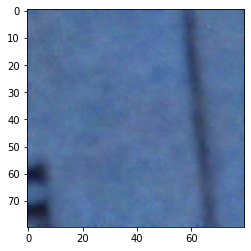

In [13]:
plt.imshow(clean_img)

In [14]:
# sending random input

clean_img = func1(n_path_lst[4444])

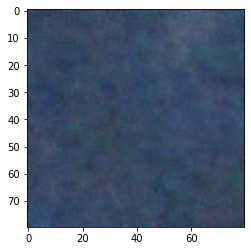

In [15]:
plt.imshow(clean_img)

In [16]:
def func2(img_path,lbl_path):

  """
    
    Function takes both noisy and clean/denoised image paths and returns the predicted image,ground truth image and psnr value.
    
    parameters:  image path (string)
    
    returns: images and psnr value
    
  """

  image_string = tf.io.read_file(img_path)
  #decoding image
  orig_image = tf.image.decode_bmp(image_string, channels=3)

  # This will convert to float values in [0, 1]
  orig_image = tf.image.convert_image_dtype(orig_image, tf.float32)

  orig_image = tf.image.resize(orig_image, [80, 80])

  pred_image = model.predict(tf.reshape(orig_image,(1,80,80,3))).reshape(80,80,3)

  image_string = tf.io.read_file(lbl_path)
  #decoding image
  y = tf.image.decode_bmp(image_string, channels=3)

  # This will convert to float values in [0, 1]
  y = tf.image.convert_image_dtype(y, tf.float32)

  y = tf.image.resize(y, [80, 80])

  # peak signal to noise ratio

  im1 = tf.image.convert_image_dtype(orig_image,tf.float32)

  im2 = tf.image.convert_image_dtype(pred_image, tf.float32)

  pred_psnr = tf.image.psnr(im1, im2, max_val=1.0)

  im1 = tf.image.convert_image_dtype(orig_image,tf.float32)

  im2 = tf.image.convert_image_dtype(y, tf.float32)

  orig_psnr = tf.image.psnr(im1, im2, max_val=1.0)

  return  pred_image , y , pred_psnr , orig_psnr

In [17]:
pred_img,gt_img,pred_psnr,orig_psnr = func2(n_path_lst[708],g_path_lst[708])

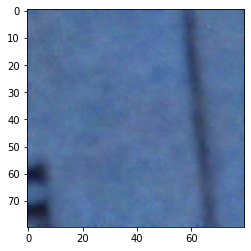

In [18]:
plt.imshow(pred_img)

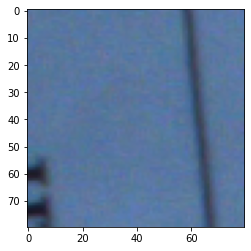

In [19]:
plt.imshow(gt_img)

In [20]:
pred_psnr

<tf.Tensor: shape=(), dtype=float32, numpy=22.252584>

In [21]:
orig_psnr

<tf.Tensor: shape=(), dtype=float32, numpy=21.908903>

In [22]:
pred_img,gt_img,pred_psnr,orig_psnr = func2(n_path_lst[4444],g_path_lst[4444])

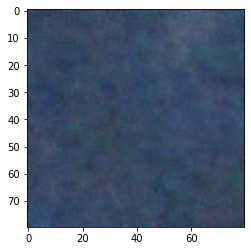

In [23]:
plt.imshow(pred_img)

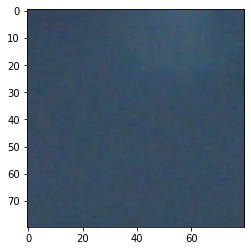

In [24]:
plt.imshow(gt_img)

In [25]:
pred_psnr

<tf.Tensor: shape=(), dtype=float32, numpy=20.807722>

In [26]:
orig_psnr

<tf.Tensor: shape=(), dtype=float32, numpy=20.183413>